In [47]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mplcolors

## set up example

In [48]:
thrust = torch.tensor([0., 0., 0., 0.99, 0.99,
          0.97373036, 0.92826162, 0.89210543, 0.86100905, 0.835423,
          0.81237673, 0.79225789, 0.77584769, 0.7629228, 0.76156073,
          0.76261984, 0.76169723, 0.75232027, 0.74026851, 0.72987175,
          0.70701647, 0.54054532, 0.45509459, 0.39343381, 0.34250785,
          0.30487242, 0.27164979, 0.24361964, 0.21973831, 0.19918151,
          0.18131868, 0.16537679, 0.15103727, 0.13998636, 0.1289037,
          0.11970413, 0.11087113, 0.10339901, 0.09617888, 0.09009926,
          0.08395078, 0.0791188, 0.07448356, 0.07050731, 0.06684119,
          0.06345518, 0.06032267, 0.05741999, 0.05472609, 0.,
          0.])

wind_speed = torch.tensor([0.,  2.,  2.5,  3.,  3.5,  4.,  4.5,  5.,  5.5,
              6.,  6.5,  7.,  7.5,  8.,  8.5,  9.,  9.5, 10.,
              10.5, 11., 11.5, 12., 12.5, 13., 13.5, 14., 14.5,
              15., 15.5, 16., 16.5, 17., 17.5, 18., 18.5, 19.,
              19.5, 20., 20.5, 21., 21.5, 22., 22.5, 23., 23.5,
              24., 24.5, 25., 25.01, 25.02, 50.])

power = torch.tensor([0., 0., 0., 0.178085, 0.289075, 0.349022,
         0.384728, 0.406059, 0.420228, 0.428823, 0.433873, 0.436223,
         0.436845, 0.436575, 0.436511, 0.436561, 0.436517, 0.435903,
         0.434673, 0.43323, 0.430466, 0.378869, 0.335199, 0.297991,
         0.266092, 0.238588, 0.214748, 0.193981, 0.175808, 0.159835,
         0.145741, 0.133256, 0.122157, 0.112257, 0.103399, 0.095449,
         0.088294, 0.081836, 0.075993, 0.070692, 0.065875, 0.061484,
         0.057476, 0.053809, 0.050447, 0.047358, 0.044518, 0.0419,
         0.039483, 0., 0.])

air_density = 1.225 # same as `examples/inputs/gch.yaml`

generator_efficiency = 1.0
turbine_hub_height = 90.0
pP = 1.88
turbine_diameter = 126.0
TSR = 8.0

rloc = 0.5
turbine_radius = turbine_diameter / 2.0

# 2x2
x_coord = torch.tensor([0., 0., 6.*turbine_diameter, 6.*turbine_diameter])
y_coord = torch.tensor([0., 3.*turbine_diameter, 0., 3.*turbine_diameter])

nturbs = len(x_coord)
z_coord = torch.tensor([90.0] * nturbs)
set_yaw = torch.tensor([np.nan] * nturbs)

y_ngrid = 3
z_ngrid = 3

# Wind parameters
ws_max = 8.0
wd_max = 360.
wd_fixed = 270.

specified_wind_height = 90.0
wind_shear = 0.12
wind_veer = 0.0
TI = 0.06

umin = torch.tensor([0.]) # min allowed yaw angle (degrees)
umax = torch.tensor([25.]) # max allowed yaw angle (degrees)

# neural net params
nturbs_needYaw = int(torch.sum(torch.isnan(set_yaw)))
model_config = dict({"n_turbines": nturbs_needYaw, "hidden_dim": 64})

# hyperparameters -> selected ad hoc; should do hyperparameter training
u_penalty = 1000.
lr = .001
batch_size = 20
num_batches = 100

## Functions

In [49]:
def cosd(angle):
    return torch.cos(torch.deg2rad(angle))

def sind(angle):
    return torch.sin(torch.deg2rad(angle))

def tand(angle):
    return torch.tan(torch.deg2rad(angle))

def interp(x, y, x_new):
    x_new_indices = torch.searchsorted(x, x_new)
    x_new_indices = x_new_indices.clip(1,len(x)-1)
    lo = x_new_indices - 1
    hi = x_new_indices
    x_lo = x[lo]
    x_hi = x[hi]
    y_lo = y[lo]
    y_hi = y[hi]
    slope = (y_hi - y_lo) / (x_hi - x_lo)
    return slope*(x_new - x_lo) + y_lo

def gaussian_function(U, C, r, n, sigma):
    return C * torch.exp(-1 * r ** n / (2 * sigma ** 2))

In [50]:
class DPCModel(nn.Module):
    def __init__(
        self,
        n_turbines: int,
        hidden_dim: int = 64,
        **kwargs
    ):
        super().__init__()
        input_size = 2 # ws, wd
        self.input_layer = nn.Linear(input_size, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, n_turbines)
        
    def forward(self, x):
        # x: state of system = torch.tensor([ws, wd])
        # u: control action (yaw angle for each turbine)
        u = F.relu(self.input_layer(x))
        u = F.relu(self.hidden_layer(u))
        u = torch.sigmoid(self.output_layer(u))
        return u

In [51]:
def get_control(ws, wd):
    ## get control action ##
    # normalize features to range [0,1] by dividing ws by ws_max and wd by wd_max
    x = torch.cat([ws/ws_max, wd/wd_max])
    u = model(x)
    clipped_u = F.relu(u*umax-umin) + umin
    clipped_u = -F.relu(-clipped_u + umax) + umax
    return u, clipped_u

In [52]:
def get_turbine_mesh():
    x_grid = torch.zeros((len(x_coord), y_ngrid, z_ngrid))
    y_grid = torch.zeros((len(x_coord), y_ngrid, z_ngrid))
    z_grid = torch.zeros((len(x_coord), y_ngrid, z_ngrid))

    angle = ((wd - 270) % 360 + 360) % 360

    x1, x2, x3 = x_coord, y_coord, z_coord

    pt = rloc * turbine_radius

    # linspace for an array; torch.linspace only takes scalar
    steps = torch.arange(y_ngrid).unsqueeze(-1) / (y_ngrid - 1)
    yt = (x2 - pt) + steps*2.*pt

    steps = torch.arange(z_ngrid).unsqueeze(-1) / (z_ngrid - 1)
    zt = (x3 - pt) + steps*2.*pt

    x_grid = torch.ones((len(x_coord), y_ngrid, z_ngrid)) * x_coord[:, None, None]
    y_grid = torch.ones((len(x_coord), y_ngrid, z_ngrid)) * yt.T[:, :, None]
    z_grid = torch.ones((len(x_coord), y_ngrid, z_ngrid)) * zt.T[:, None, :]

    # yaw turbines to be perpendicular to the wind direction
    wind_direction_i = angle[None, :, None, None, None, None]
    xoffset = x_grid - x1[:, None, None]
    yoffset = y_grid - x2[:, None, None]
    wind_cos = cosd(-wind_direction_i)
    wind_sin = sind(-wind_direction_i)
    x_grid = xoffset * wind_cos - yoffset * wind_sin + x1[:, None, None]
    y_grid = yoffset * wind_cos + xoffset * wind_sin + x2[:, None, None]

    mesh_x = x_grid
    mesh_y = y_grid
    mesh_z = z_grid

    # rotate turbine locations/fields to be perpendicular to wind direction
    x_center_of_rotation = torch.mean(torch.stack([torch.min(mesh_x), torch.max(mesh_x)]))
    y_center_of_rotation = torch.mean(torch.stack([torch.min(mesh_y), torch.max(mesh_y)]))
    angle = ((wd[None, :, None, None, None, None] - 270) % 360 + 360) % 360
    x_offset = mesh_x - x_center_of_rotation
    y_offset = mesh_y - y_center_of_rotation
    mesh_x_rotated = (x_offset * cosd(angle) - y_offset * sind(angle) 
                      + x_center_of_rotation)
    mesh_y_rotated = (x_offset * sind(angle) + y_offset * cosd(angle) 
                      + y_center_of_rotation)
    x_coord_offset = (x_coord - x_center_of_rotation)[:, None, None]
    y_coord_offset = (y_coord - y_center_of_rotation)[:, None, None]
    x_coord_rotated = (x_coord_offset * cosd(angle)
        - y_coord_offset * sind(angle)
        + x_center_of_rotation)
    y_coord_rotated = (x_coord_offset * sind(angle)
        + y_coord_offset * cosd(angle)
        + y_center_of_rotation)
    inds_sorted = x_coord_rotated.argsort(axis=3)

    x_coord_rotated = torch.gather(x_coord_rotated, 3, inds_sorted)
    y_coord_rotated = torch.gather(y_coord_rotated, 3, inds_sorted)
    z_coord_rotated = torch.gather(z_coord * np.ones((np.shape(x_coord_rotated))), 
                                   3, inds_sorted)
    
    mesh_x_rotated = torch.take_along_dim(mesh_x_rotated, inds_sorted, 3)
    mesh_y_rotated = torch.take_along_dim(mesh_y_rotated, inds_sorted, 3)
    mesh_z_rotated = torch.take_along_dim(mesh_z * np.ones((np.shape(mesh_x_rotated))), 
                                          inds_sorted, 3)
  
    return x_coord_rotated, y_coord_rotated, z_coord_rotated, \
        mesh_x_rotated, mesh_y_rotated, mesh_z_rotated, mesh_z

In [53]:
def get_field_rotor(ws, wd, clipped_u, set_yaw):
    ## initialize flow field ##
    x_coord_rotated, y_coord_rotated, z_coord_rotated, \
        mesh_x_rotated, mesh_y_rotated, mesh_z_rotated, mesh_z = get_turbine_mesh()
    
    flow_field_u_initial = (ws[None, None, :, None, None, None] 
                        * (mesh_z / specified_wind_height) ** wind_shear) \
                        * np.ones((1, len(wd), 1, 1, 1, 1))

    ## initialize other field values ##
    u_wake = torch.zeros(np.shape(flow_field_u_initial))
    flow_field_u = flow_field_u_initial - u_wake
    turb_inflow_field = torch.ones(np.shape(flow_field_u_initial)) * flow_field_u_initial

    ## Initialize turbine values ##
    turb_TIs = torch.ones_like(x_coord_rotated) * TI
    ambient_TIs = torch.ones_like(x_coord_rotated) * TI
    masked_u = torch.clone(set_yaw)
    masked_u[masked_u.isnan()] = clipped_u
    yaw_angle = masked_u.reshape(x_coord_rotated.shape)
    turbine_tilt = torch.ones_like(x_coord_rotated) * 0.0

    # Loop over turbines to solve wakes
    for i in range(len(x_coord)):
        turb_inflow_field = turb_inflow_field \
        * (mesh_x_rotated != x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :]) \
        + (flow_field_u_initial - u_wake) \
        * (mesh_x_rotated == x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :])

        turb_avg_vels = torch.pow(torch.mean(turb_inflow_field ** 3, dim=(4,5)), 1./3.)

        Ct = interp(wind_speed, thrust, turb_avg_vels)
        yaw_angle_flat = torch.squeeze(torch.squeeze(yaw_angle, dim=4), dim=4)
        Ct *= cosd(yaw_angle_flat) # effective thrust
        Ct = Ct * (Ct < 1.0) + 0.9999 * torch.ones_like(Ct) * (Ct >= 1.0)
        turb_Cts = Ct * (Ct > 0.0) + 0.0001 * torch.ones_like(Ct) * (Ct <= 0.0)

        turb_aIs = 0.5 / cosd(yaw_angle_flat) * (1 - torch.sqrt(1 - turb_Cts * cosd(yaw_angle_flat) + 1e-16))

        ## Wake deflection calculation ##
        yaw = yaw_angle # if no secondary steering    
        x_coord_rotated_i = x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :]
        y_coord_rotated_i = y_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :]
        turbine_ti_i = turb_TIs[:, :, :, i, :, :][:, :, :, None, :, :]
        turbine_Ct_i = turb_Cts[:, :, :, i][:, :, :, None, None, None]
        yaw_i = yaw[:, :, :, i, :, :][:, :, :, None, :, :]
        neg_yaw_i = -1. * yaw_i # wake deflection has opposite sign convention
        
        ka = 0.38  # wake expansion parameter
        kb = 0.004  # wake expansion parameter
        alpha = 0.58  # near wake parameter
        beta = 0.077  # near wake parameter
        ad = 0.0  # natural lateral defleturbine_Ct_iion parameter
        bd = 0.0  # natural lateral defleturbine_Ct_iion parameter
        dm = 1.0

        U_local = flow_field_u_initial

        # initial velocity deficits
        uR = (U_local * turbine_Ct_i * cosd(turbine_tilt) * cosd(neg_yaw_i)
              / (2.0 * (1 - torch.sqrt(1 - (turbine_Ct_i * cosd(turbine_tilt) * cosd(neg_yaw_i)) + 1e-16))))
        u0 = U_local * torch.sqrt(1 - turbine_Ct_i + 1e-16)

        # length of near wake
        x0 = (turbine_diameter
              * (cosd(neg_yaw_i) * (1 + torch.sqrt(1 - turbine_Ct_i * cosd(neg_yaw_i) + 1e-16)))
              / (np.sqrt(2) * (4 * alpha * turbine_ti_i + 2 * beta * (1 - torch.sqrt(1 - turbine_Ct_i + 1e-16))))
              + x_coord_rotated_i)

        # wake expansion parameters
        ky = ka * turbine_ti_i + kb
        kz = ka * turbine_ti_i + kb

        C0 = 1 - u0 / flow_field_u_initial
        M0 = C0 * (2 - C0)
        E0 = C0 ** 2 - 3 * np.exp(1.0 / 12.0) * C0 + 3 * np.exp(1.0 / 3.0)

        # initial Gaussian wake expansion
        sigma_z0 = turbine_diameter * 0.5 * torch.sqrt(uR / (U_local + u0) + 1e-16)
        sigma_y0 = sigma_z0 * cosd(neg_yaw_i) * cosd(torch.tensor(wind_veer))

        yR = mesh_y_rotated - y_coord_rotated_i
        xR = x_coord_rotated_i

        # yaw_i parameter (skew angle)
        theta_c0 = (dm * (0.3 * torch.deg2rad(neg_yaw_i) / cosd(neg_yaw_i)) 
                    * (1 - torch.sqrt(1 - turbine_Ct_i * cosd(neg_yaw_i) + 1e-16))) # skew angle in radians

        # yaw_i param (distance from centerline=initial wake deflection)
        # NOTE: use tan here since theta_c0 is radians
        delta0 = torch.tan(theta_c0) * (x0 - x_coord_rotated_i) 

        # deflection in the near wake
        delta_near_wake = ((mesh_x_rotated - xR) / (x0 - xR)) * delta0 \
            + (ad + bd * (mesh_x_rotated - x_coord_rotated_i))
        delta_near_wake = delta_near_wake * (mesh_x_rotated >= xR)
        delta_near_wake = delta_near_wake * (mesh_x_rotated <= x0)

        # deflection in the far wake
        sigma_y = ky * (mesh_x_rotated - x0) + sigma_y0
        sigma_z = kz * (mesh_x_rotated - x0) + sigma_z0
        sigma_y = sigma_y * (mesh_x_rotated >= x0) + sigma_y0 * (mesh_x_rotated < x0)
        sigma_z = sigma_z * (mesh_x_rotated >= x0) + sigma_z0 * (mesh_x_rotated < x0)

        ln_deltaNum = (1.6 + torch.sqrt(M0 + 1e-16)) \
            * (1.6 * torch.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0) + 1e-16) - torch.sqrt(M0 + 1e-16))
        ln_deltaDen = (1.6 - torch.sqrt(M0)) \
            * (1.6 * torch.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0) + 1e-16) + torch.sqrt(M0 + 1e-16))
        delta_far_wake = (delta0 + (theta_c0 * E0 / 5.2)
                          * torch.sqrt(sigma_y0 * sigma_z0 / (ky * kz * M0) + 1e-16)
                          * torch.log(ln_deltaNum / ln_deltaDen)
                          + (ad + bd * (mesh_x_rotated - x_coord_rotated_i)))
        delta_far_wake = delta_far_wake * (mesh_x_rotated > x0)
        deflection_field = delta_near_wake + delta_far_wake

        ## Calculate wake deficits ##
        # wake deflection
        delta = deflection_field

        # mask upstream wake
        xR = x_coord_rotated_i

        # mask upstream wake
        #   initial velocity deficits
        uR = U_local * turbine_Ct_i / (2.0 * (1. - torch.sqrt(1. - turbine_Ct_i + 1e-16)))
        u0 = U_local * torch.sqrt(1. - turbine_Ct_i + 1e-16)
        #   initial wake expansion
        sigma_z0 = turbine_diameter * 0.5 * torch.sqrt(uR / (U_local + u0) + 1e-16)
        sigma_y0 = sigma_z0 * cosd(neg_yaw_i) * cosd(torch.tensor(wind_veer))

        # quantity that determines when the far wake starts
        x0 = (turbine_diameter * (cosd(neg_yaw_i) * (1. + torch.sqrt(1. - turbine_Ct_i + 1e-16)))
              / (np.sqrt(2.) * (4. * alpha * turbine_ti_i + 2. * beta 
                                   * (1. - torch.sqrt(1. - turbine_Ct_i + 1e-16))))
              + x_coord_rotated_i)

        # velocity deficit in the near wake
        turb_u_wake = torch.zeros_like(U_local)
        near_wake_mask = (mesh_x_rotated > xR + 0.1) * (mesh_x_rotated < x0)
        if torch.sum(near_wake_mask):
            sigma_y = (((x0 - xR) - (mesh_x_rotated - xR)) / (x0 - xR)) * 0.501 * turbine_diameter \
                * torch.sqrt(turbine_Ct_i / 2. + 1e-16) + ((mesh_x_rotated - xR) / (x0 - xR)) * sigma_y0
            sigma_z = (((x0 - xR) - (mesh_x_rotated - xR)) / (x0 - xR)) * 0.501 * turbine_diameter \
                * torch.sqrt(turbine_Ct_i / 2. + 1e-16) + ((mesh_x_rotated - xR) / (x0 - xR)) * sigma_z0

            sigma_y = (sigma_y * (mesh_x_rotated >= xR) + torch.ones_like(sigma_y) 
                       * (mesh_x_rotated < xR) * 0.5 * turbine_diameter)
            sigma_z = (sigma_z * (mesh_x_rotated >= xR) + torch.ones_like(sigma_z) 
                       * (mesh_x_rotated < xR) * 0.5 * turbine_diameter)

            wind_veer_tensor = torch.tensor(wind_veer)
            a = cosd(wind_veer_tensor) ** 2 / (2 * sigma_y ** 2) + sind(wind_veer_tensor) ** 2 / (2 * sigma_z ** 2)
            b = -sind(2 * wind_veer_tensor) / (4 * sigma_y ** 2) + sind(2 * wind_veer_tensor) / (4 * sigma_z ** 2)
            c = sind(wind_veer_tensor) ** 2 / (2 * sigma_y ** 2) + cosd(wind_veer_tensor) ** 2 / (2 * sigma_z ** 2)
            r = (a * ((mesh_y_rotated - y_coord_rotated_i) - delta) ** 2
                 - 2 * b * ((mesh_y_rotated - y_coord_rotated_i) - delta) * ((mesh_z - turbine_hub_height))
                 + c * ((mesh_z - turbine_hub_height)) ** 2)

            C = 1 - torch.sqrt(torch.clip(1 - (turbine_Ct_i * cosd(neg_yaw_i) 
                / (8.0 * sigma_y * sigma_z / turbine_diameter ** 2)), 0.0, 1.0) + 1e-16)

            turb_u_wake = gaussian_function(U_local, C, r, 1, np.sqrt(0.5)) * near_wake_mask

        far_wake_mask = (mesh_x_rotated >= x0)
        if torch.sum(far_wake_mask):
            # wake expansion in the lateral (y) and the vertical (z)
            sigma_y = ky * (mesh_x_rotated - x0) + sigma_y0
            sigma_z = kz * (mesh_x_rotated - x0) + sigma_z0
            sigma_y = sigma_y * (mesh_x_rotated >= x0) + sigma_y0 * (mesh_x_rotated < x0)
            sigma_z = sigma_z * (mesh_x_rotated >= x0) + sigma_z0 * (mesh_x_rotated < x0)

            # velocity deficit outside the near wake
            wind_veer_tensor = torch.tensor(wind_veer)
            a = cosd(wind_veer_tensor) ** 2 / (2 * sigma_y ** 2) + sind(wind_veer_tensor) ** 2 / (2 * sigma_z ** 2)
            b = -sind(2 * wind_veer_tensor) / (4 * sigma_y ** 2) + sind(2 * wind_veer_tensor) / (4 * sigma_z ** 2)
            c = sind(wind_veer_tensor) ** 2 / (2 * sigma_y ** 2) + cosd(wind_veer_tensor) ** 2 / (2 * sigma_z ** 2)
            r = (a * (mesh_y_rotated - y_coord_rotated_i - delta) ** 2
                 - 2 * b * (mesh_y_rotated - y_coord_rotated_i - delta) * (mesh_z - turbine_hub_height)
                 + c * (mesh_z - turbine_hub_height) ** 2)
            C = 1 - torch.sqrt(torch.clip(1 - (turbine_Ct_i * cosd(neg_yaw_i) 
                / (8.0 * sigma_y * sigma_z / turbine_diameter ** 2)), 0.0, 1.0) + 1e-16)

            # compute velocities in the far wake
            turb_u_wake1 = gaussian_function(U_local, C, r, 1, np.sqrt(0.5)) * far_wake_mask
            turb_u_wake += turb_u_wake1

        ## Perform wake/field combinations ##
        u_wake = torch.sqrt((u_wake ** 2) + ((turb_u_wake * flow_field_u_initial) ** 2) + 1e-16)
        flow_field_u = flow_field_u_initial - u_wake

        ## Calculate wake overlap for wake-added turbulence (WAT) ##
        area_overlap = torch.sum(turb_u_wake * flow_field_u_initial > 0.05, axis=(4, 5)) / (y_ngrid * z_ngrid)

        ## Calculate WAT for turbines ##
        # turbulence intensity calculation based on Crespo et. al.
        turbine_aI_i = turb_aIs[:, :, :, i][:, :, :, None, None, None]
        ti_initial = 0.1
        ti_constant = 0.5
        ti_ai = 0.8
        ti_downstream = -0.32

        # replace zeros and negatives with 1 to prevent nans/infs
        # keep downstream components; set upstream to 1.0
        delta_x = mesh_x_rotated - x_coord_rotated_i
        upstream_mask = (delta_x <= 0.1)
        downstream_mask = (delta_x > -0.1)
        delta_x = delta_x * downstream_mask + torch.ones_like(delta_x) * upstream_mask
        ti_calculation = (ti_constant * turbine_aI_i ** ti_ai * ambient_TIs ** ti_initial \
                          * (delta_x / turbine_diameter) ** ti_downstream)

        # mask the 1 values from above w/ zeros
        WAT_TIs = ti_calculation * downstream_mask

        ## Modify WAT by wake area overlap ##
        # TODO: will need to make the rotor_diameter part of this mask work for
        # turbines of different types
        downstream_influence_length = 15 * turbine_diameter
        ti_added = (area_overlap[:, :, :, :, None, None] * torch.nan_to_num(WAT_TIs, posinf=0.0) 
            * (x_coord_rotated > x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :])
            * (torch.abs(y_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :] - y_coord_rotated) 
               < 2 * turbine_diameter)
            * (x_coord_rotated <= downstream_influence_length
               + x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :]))

        ## Combine turbine TIs with WAT
        turb_TIs = torch.maximum(torch.sqrt(ti_added ** 2 + ambient_TIs ** 2 + 1e-16), turb_TIs,)    
        
    return flow_field_u, x_coord_rotated, yaw_angle

In [54]:
def get_power(flow_field_u, x_coord_rotated, yaw_angle):
    ## power calculation (based on main floris branch) ##
    # omitted fCp_interp b/c interp power from wind_speed to wind_speed so does nothing...
    rotor_area = torch.pi * turbine_radius ** 2.0
    inner_power = 0.5*rotor_area*power*generator_efficiency*wind_speed**3

    # omiting some lines here b/c assuming all turbines have same type
    # ix_filter not implemented

    # Compute the yaw effective velocity
    pPs = torch.ones_like(x_coord_rotated) * 1.88 # `turbine_library/nrel_5MW.yaml`
    pW = pPs / 3.0  # Convert from pP to w
    axis = tuple([4 + i for i in range(flow_field_u.ndim - 4)])
    average_velocity = torch.pow(torch.mean(flow_field_u ** 3, axis=axis), 1./3.).reshape(yaw_angle.shape)
    yaw_effective_velocity = ((air_density/1.225)**(1/3)) * average_velocity * cosd(yaw_angle) ** pW

    # Power produced by a turbine adjusted for yaw and tilt. Value given in kW
    p = 1.225 * interp(wind_speed, inner_power, yaw_effective_velocity) / 1000.0

    # negative sign on power b/c good -> want to minimize
    return p

## Training

In [55]:
# init DPC model
model = DPCModel(**model_config)

# init training
opt = torch.optim.Adam(model.parameters(), lr=lr)

opt_losses = []
u_viol_losses = []
power_losses = []
test_powers = []

# evaluate and save performance of untrained model on test set
# note: test set only used to evaluate performance; not used for training
ws_test = torch.tensor([[4.], [5.], [6.], [7.], [8.]])
wd = torch.tensor([wd_fixed])
test_power = 0.
for ws in ws_test:
    u, clipped_u = get_control(ws, wd)
    flow_field_u, x_coord_rotated, yaw_angle = get_field_rotor(ws, wd, clipped_u, set_yaw)
    p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
    test_power += -torch.sum(p)
test_power /= len(ws_test)
test_powers.append(test_power.detach().numpy())

# train
for batch in range(num_batches):
    if (batch+1) % 10 == 0:
        print("batch: %d/%d. \n"%(batch+1, num_batches))
            
    opt_loss = 0.
    u_viol_loss = 0.
    power_loss = 0.
    ws_all = []
    wd_all = []
    u_all = []
    clipped_u_all = []

    # forward pass
    for sample in range(batch_size):
        # generate training data at random from desired range
        # for real farm, would use historical ws and wd data instead
        ws = torch.rand(1) * ws_max # ws from [0, ws_max]   
        wd = torch.tensor([wd_fixed]) # to do: add option to train for varying wd
        ws_all.append(ws.detach().numpy())
        wd_all.append(wd.detach().numpy())

        u, clipped_u = get_control(ws, wd)
        flow_field_u, x_coord_rotated, yaw_angle = get_field_rotor(ws, wd, clipped_u, set_yaw)
        p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
        power_cost = -torch.sum(p)
        u_all.append(u.detach().numpy())
        clipped_u_all.append((clipped_u/umax).detach().numpy())

        # cost from soft constraints (violating bounds on yaw angle)
        u_viol_lower = F.relu(umin - u)
        u_viol_upper = F.relu(u - umax)
        u_viol_cost = u_penalty * torch.sum(torch.sqrt(u_viol_lower.pow(2) + u_viol_upper.pow(2) +1e-16))

        # total cost
        total_cost = u_viol_cost + power_cost

        # sum over data in batch
        opt_loss += total_cost
        u_viol_loss += u_viol_cost
        power_loss += power_cost

    opt_loss /= batch_size
    u_viol_loss /= batch_size
    power_loss /= batch_size

    # backward pass
    opt.zero_grad()
    opt_loss.backward()
    opt.step()

    opt_losses.append(opt_loss.detach().numpy())
    u_viol_losses.append(u_viol_loss.detach().numpy())
    power_losses.append(power_loss.detach().numpy())
    
    wd = torch.tensor([wd_fixed])
    test_power = 0.
    for ws in ws_test:
        u, clipped_u = get_control(ws, wd)
        flow_field_u, x_coord_rotated, yaw_angle = get_field_rotor(ws, wd, clipped_u, set_yaw)
        p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
        test_power += -torch.sum(p)
    test_power /= len(ws_test)
    test_powers.append(test_power.detach().numpy())

batch: 10/100. 

batch: 20/100. 

batch: 30/100. 

batch: 40/100. 

batch: 50/100. 

batch: 60/100. 

batch: 70/100. 

batch: 80/100. 

batch: 90/100. 

batch: 100/100. 



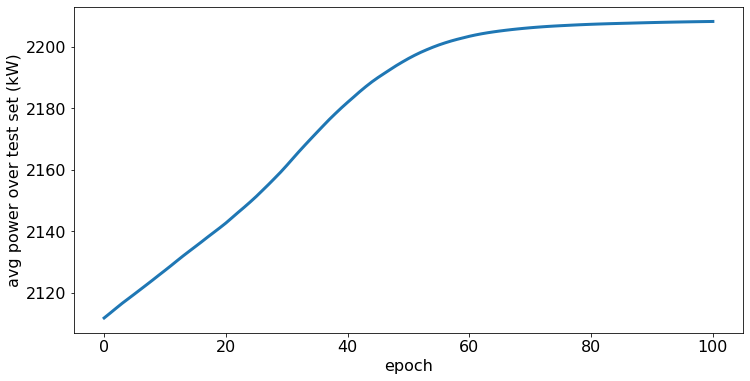

In [56]:
# power for test set from FLORIS model (baseline and optimized)
# FLORIS_baseline = (4483. + 2948. + 1771. + 923. + 364.)/5.
# FLORIS_opt = (4662. + 3094. + 1882. + 1003. + 406.)/5.

plt.rcParams.update({'font.size': 16})
plt.plot(-np.array(test_powers), label='DPC', color='tab:blue', linestyle='-', linewidth=3)
# plt.axhline(FLORIS_opt, label='lookup table', color='tab:orange', linestyle='--', linewidth=3)
# plt.axhline(FLORIS_baseline, label='baseline', color='tab:green', linestyle=':', linewidth=3)
plt.xlabel('epoch')
plt.ylabel('avg power over test set (kW)')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [57]:
ws = torch.tensor([8.0])
wd = torch.tensor([wd_fixed])

u = torch.tensor([25., 25., 0., 0.])
flow_field_u, x_coord_rotated, yaw_angle = get_field_rotor(ws, wd, u, set_yaw)
p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("optimal power: ", np.round(torch.sum(p).detach().numpy(), 0))

u, clipped_u = get_control(ws, wd)
flow_field_u, x_coord_rotated, yaw_angle = get_field_rotor(ws, wd, clipped_u, set_yaw)
p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("DPC power: ", np.round(torch.sum(p).detach().numpy(), 0))
print("DPC yaw: ", np.round((u*umax).detach().numpy(), 0))

u = torch.tensor([0., 0., 0., 0.])
flow_field_u, x_coord_rotated, yaw_angle = get_field_rotor(ws, wd, u, set_yaw)
p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("unyawed power: ", np.round(torch.sum(p).detach().numpy(), 0))

print("")

optimal power:  4662.0
DPC power:  4661.0
DPC yaw:  [25. 25.  1.  1.]
unyawed power:  4483.0



## Power and velocity given control action
doesn't use DPC; this just tests the pytorch implementation of FLORIS

In [58]:
u = torch.tensor([0., 0., 25., 25.])
flow_field_u, x_coord_rotated, yaw_angle = get_field_rotor(ws, wd, u, set_yaw)
p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("power: ", np.round(torch.sum(p).detach().numpy(), 0))

power:  4284.0


In [59]:
list(np.round(x_coord_rotated.detach().numpy(), 2).flatten())

[0.0, 0.0, 756.0, 756.0]

In [60]:
# this matches floris
flow_field_u

tensor([[[[[[7.5970, 8.0000, 8.2934],
            [7.5970, 8.0000, 8.2934],
            [7.5970, 8.0000, 8.2934]],

           [[7.5970, 8.0000, 8.2934],
            [7.5970, 8.0000, 8.2934],
            [7.5970, 8.0000, 8.2934]],

           [[5.5905, 5.3922, 6.1030],
            [5.1206, 4.7814, 5.5899],
            [5.5905, 5.3922, 6.1030]],

           [[5.5905, 5.3922, 6.1030],
            [5.1206, 4.7814, 5.5899],
            [5.5905, 5.3922, 6.1030]]]]]], dtype=torch.float64)

## Plot velocity values on rotor disk

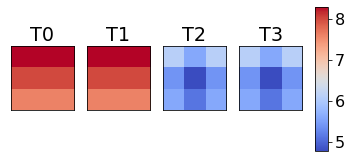

In [61]:
# plotting settings
t_range = None
wd_index = 0
ws_index = 0
n_rows = 1
n_cols = 4
cmap = "coolwarm"
save_path = False

#plot rotor values
cmap = plt.cm.get_cmap(name=cmap)
if t_range is None:
    t_range = range(flow_field_u.shape[3])
    
fig = plt.figure()
axes = fig.subplots(n_rows, n_cols)

indices = t_range
titles = np.array([f"T{i}" for i in indices])

for ax, t, i in zip(axes.flatten(), titles, indices):
    vmin = torch.min(flow_field_u[wd_index, ws_index])
    vmax = torch.max(flow_field_u[wd_index, ws_index])

    bounds = np.linspace(vmin, vmax, 31)
    norm = mplcolors.Normalize(vmin, vmax)

    ax.imshow(flow_field_u[0, wd_index, ws_index, i].T, cmap=cmap, norm=norm, origin="lower")
    ax.invert_xaxis()

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(t)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.25, 0.03, 0.5])
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)

#plt.savefig(save_path, bbox_inches="tight")
plt.show()